# Exercise 4.2: Solve CIFAR classification with CNNs in tensorflow or pytorch

Advanced Machine Learning for KCS

by Stefan Heinrich, Stella Grasshof, Laura Weihl
with material by Kevin Murphy

All info and static material: https://learnit.itu.dk/course/view.php?id=3021295

-------------------------------------------------------------------------------

*Note: the notebook for exercise 4.1 as well as this stub are prepared for PyTorch. You can easily find examples for TensorFlow online and are free to choose to work with TensorFlow instead!*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

#### Load CIFAR-10 from tensorflow or pytorch

In [2]:
batch_size = 32

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


##### Preprocessing

In [4]:
print(len(trainset))
print(len(testset))
img_size = trainloader.dataset.data.shape[1]
print(img_size)
#class_out = trainloader.dataset.classes.unique().size()[0]
class_out = len(set(trainloader.dataset.targets))
print(class_out)

50000
10000
32
10


##### Show some data characteristics

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


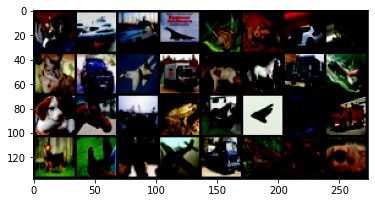

In [5]:
NO_images = 32

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(testloader)
images = []
for _ in range(NO_images):
    image, label = next(dataiter)
    image = torch.squeeze(image, 0)
    images.append(image)

images = torch.stack(images).cpu()

imshow(torchvision.utils.make_grid(images))

In [6]:

#hist1 = {i:0 for i in range(10)}
#for (images, labels) in trainloader:
#    for label in labels:
#        hist1[label.item()] += 1
#
#hist2 = {i:0 for i in range(10)}
#for (images, labels) in testloader:
#    for label in labels:
#        hist2[label.item()] += 1
#
#fig, ax = plt.subplots(1,2)
#ax[0].bar(list(hist1.keys()), hist1.values())
#ax[0].set_xticks(range(0,10))
#ax[0].set_ylim(0, 5000)
#
#ax[1].bar(list(hist2.keys()), hist2.values())
#ax[1].set_xticks(range(0,10))
#ax[1].set_ylim(0, 1000)
#plt.show()

#### Build the model

In [137]:
device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')

def get_output_shape(layer, img_size):
    return layer(torch.rand(*(img_size))).data.shape

class ModelClass(nn.Module):
    def __init__(self, img_size, fc1_out, class_out):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        flattened = int(((32-5+1)/2 - 3+1)/2)
        self.fc1 = nn.Linear(16 * flattened * flattened, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ModelClass(img_size, 120, class_out)
model = model.to(device)
print(model)
#model.summary(show_trainable=True)

ModelClass(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### Train the model

In [126]:
learning_rate = 0.001
#learning_rate = 0.01
momentum = 0.9
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [127]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

##### Training loop

In [128]:
train_acc_list = []
train_loss_list = []
for epoch in range(epochs):
    model = model.train()

    train_running_loss = 0.0
    train_acc = 0.0
    for idx, (images, labels) in enumerate(trainloader, 0):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #set gradient to zero instead of accumulating

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, batch_size)
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / idx, train_acc/idx))
    train_acc_list.append(train_acc/idx)
    train_loss_list.append(train_running_loss/idx)

Epoch: 0 | Loss: 2.1831 | Train Accuracy: 18.70
Epoch: 1 | Loss: 1.8062 | Train Accuracy: 34.61
Epoch: 2 | Loss: 1.5717 | Train Accuracy: 42.45
Epoch: 3 | Loss: 1.4574 | Train Accuracy: 46.96
Epoch: 4 | Loss: 1.3744 | Train Accuracy: 50.36
Epoch: 5 | Loss: 1.3075 | Train Accuracy: 52.99
Epoch: 6 | Loss: 1.2494 | Train Accuracy: 55.42
Epoch: 7 | Loss: 1.1889 | Train Accuracy: 57.54
Epoch: 8 | Loss: 1.1366 | Train Accuracy: 59.63
Epoch: 9 | Loss: 1.0919 | Train Accuracy: 61.44


##### Analyse some training progress

In [89]:
#loss and accuracy
model = model.eval()
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, 1)

print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")

Test Accuracy: 61.75617561756176, in epoch: 9


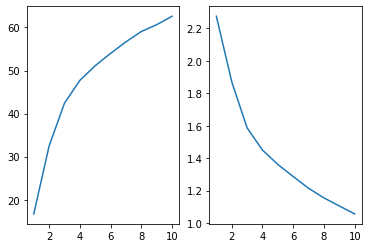

In [90]:
#Plot graphs of loss and accuracy on train and test data to see if we overfit...
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.linspace(1, len(train_acc_list), len(train_acc_list)), train_acc_list)
ax[1].plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list)

#### Analyse the model

In [91]:
#accuracy of whole test set
correct = 0
total = 0
with torch.no_grad():
    for (images, labels) in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [92]:
#Accuracy for each class in test set
predicted = []
correct = []

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for (images, labels) in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            predicted.append(prediction)
            correct.append(label)



# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.8 %
Accuracy for class: car   is 81.7 %
Accuracy for class: bird  is 51.7 %
Accuracy for class: cat   is 44.3 %
Accuracy for class: deer  is 60.5 %
Accuracy for class: dog   is 41.0 %
Accuracy for class: frog  is 62.8 %
Accuracy for class: horse is 69.7 %
Accuracy for class: ship  is 74.5 %
Accuracy for class: truck is 61.5 %


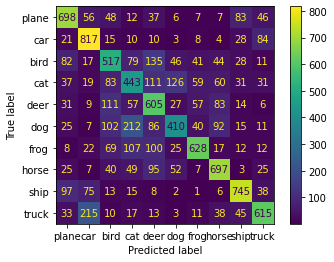

In [99]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
correct1 = [x.item() for x in correct]
predicted1 = [x.item() for x in predicted]
ConfusionMatrixDisplay.from_predictions(correct1, predicted1, display_labels=classes)

#### Brief experiment with different settings

In [74]:
#parameters
batch_sizes = [4, 32]
learning_rates = [0.0001, 0.001, 0.005, 0.01]
kernel1 = [3, 5, 7]
kernel2 = [3, 5, 7]
momentum = 0.9
epochs = 10

In [75]:
class Model(nn.Module):
    def __init__(self, kernel1, kernel2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, kernel2)
        flattened = int(((32-kernel1+1)/2 - kernel2+1)/2)
        self.fc1 = nn.Linear(16 * flattened * flattened, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
#df = pd.DataFrame(columns=['batch_size', 'learning_rate','kernel1', 'kernel2', 'test_accuracy'])
df = pd.read_pickle("cifar_across_models.pkl")

for batch_size in batch_sizes:
    #load data
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

    for learning_rate in learning_rates:
        for k1 in kernel1:
            for k2 in kernel2:
                print('starting on: batch_size: %d | learning_rate: %.4f | k1: %d | k2: %d' %(batch_size, learning_rate, k1, k2))
                model = Model(k1, k2)
                model = model.to(device)

                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) #could also add momentum as variable

                #train model
                for epoch in range(epochs):
                    model = model.train()

                    train_running_loss = 0.0
                    train_acc = 0.0
                    for idx, (images, labels) in enumerate(trainloader, 0):
                        images = images.to(device)
                        labels = labels.to(device)

                        optimizer.zero_grad() #set gradient to zero instead of accumulating

                        ## forward + backprop + loss
                        logits = model(images)
                        loss = criterion(logits, labels)
                        loss.backward()

                        ## update model params
                        optimizer.step()

                        train_running_loss += loss.detach().item()
                        train_acc += get_accuracy(logits, labels, batch_size)
                    
                    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
                        %(epoch, train_running_loss / idx, train_acc/idx))
                
                
                #test model
                correct = 0
                total = 0
                with torch.no_grad():
                    for (images, labels) in testloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                test_acc = 100 * correct / total
                print('Reached test accuracy: %.2f' %(test_acc))

                df = df.append({'batch_size': batch_size, 'learning_rate': learning_rate, 'kernel1': k1, 'kernel2': k2, 'test_accuracy': test_acc}, ignore_index=True)
                df.to_pickle('cifar_across_models.pkl')
                

starting on: batch_size: 32 | learning_rate: 0.0010 | k1: 5 | k2: 3
Epoch: 0 | Loss: 2.2411 | Train Accuracy: 16.95
Epoch: 1 | Loss: 1.8924 | Train Accuracy: 32.16
Epoch: 2 | Loss: 1.6444 | Train Accuracy: 40.36
Epoch: 3 | Loss: 1.4983 | Train Accuracy: 45.78
Epoch: 4 | Loss: 1.3951 | Train Accuracy: 49.93
Epoch: 5 | Loss: 1.3119 | Train Accuracy: 53.24
Epoch: 6 | Loss: 1.2429 | Train Accuracy: 55.68
Epoch: 7 | Loss: 1.1842 | Train Accuracy: 58.09
Epoch: 8 | Loss: 1.1331 | Train Accuracy: 59.96
Epoch: 9 | Loss: 1.0858 | Train Accuracy: 61.69
Reached test accuracy: 60.22


/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_28101/3105655994.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'batch_size': batch_size, 'learning_rate': learning_rate, 'kernel1': k1, 'kernel2': k2, 'test_accuracy': test_acc}, ignore_index=True)


In [133]:
#Visualize all of this to summarize
#df.to_pickle('cifar_across_models2.pkl')
#display(df)

In [78]:
output = pd.read_pickle("cifar_across_models.pkl")
output = output.sort_values(by=['test_accuracy'], ascending=False)
output

,batch_size,learning_rate,kernel1,kernel2,test_accuracy
12,4.0,0.0010,5.0,3.0,65.66
30,32.0,0.0050,3.0,3.0,64.12
14,4.0,0.0010,5.0,7.0,63.28
9,4.0,0.0010,3.0,3.0,63.26
26,32.0,0.0050,5.0,3.0,63.08
13,4.0,0.0010,5.0,5.0,62.66
31,32.0,0.0100,3.0,3.0,62.34
10,4.0,0.0010,3.0,5.0,62.20
24,32.0,0.0100,5.0,3.0,62.05
32,32.0,0.0010,5.0,3.0,60.22


## 4.3 Training with dropouts


In [129]:
class Model_dropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        flattened = int(((32-5+1)/2 - 3+1)/2)
        self.fc1 = nn.Linear(16 * flattened * flattened, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dropouts = [0.1, 0.3, 0.5]
df2 = pd.DataFrame(columns=['dropout', 'train_accuracy', 'test_accuracy'])

In [131]:
for dropout in dropouts:
    print('starting on: dropout: %.1f' %(dropout))
    model = Model_dropout(dropout)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum) #could also add momentum as variable

    #train model
    train_accuracy = 0.0
    for epoch in range(epochs):
        model = model.train()

        train_running_loss = 0.0
        train_acc = 0.0
        for idx, (images, labels) in enumerate(trainloader, 0):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() #set gradient to zero instead of accumulating

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(logits, labels, batch_size)
        
        train_accuracy = train_acc/idx
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / idx, train_accuracy))
    
    
    #test model
    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print('Reached test accuracy: %.2f' %(test_acc))

    df2 = df2.append({'dropout': dropout, 'train_accuracy': train_accuracy, 'test_accuracy': test_acc}, ignore_index=True)

starting on: dropout: 0.1
Epoch: 0 | Loss: 2.2430 | Train Accuracy: 18.11
Epoch: 1 | Loss: 1.8536 | Train Accuracy: 32.69
Epoch: 2 | Loss: 1.6169 | Train Accuracy: 41.13
Epoch: 3 | Loss: 1.5073 | Train Accuracy: 45.31
Epoch: 4 | Loss: 1.4222 | Train Accuracy: 48.54
Epoch: 5 | Loss: 1.3610 | Train Accuracy: 51.27
Epoch: 6 | Loss: 1.3045 | Train Accuracy: 53.16
Epoch: 7 | Loss: 1.2605 | Train Accuracy: 54.85
Epoch: 8 | Loss: 1.2116 | Train Accuracy: 56.88
Epoch: 9 | Loss: 1.1744 | Train Accuracy: 58.12
Reached test accuracy: 58.27
starting on: dropout: 0.3


/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_28101/458182116.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'dropout': dropout, 'train_accuracy': train_accuracy, 'test_accuracy': test_acc}, ignore_index=True)


Epoch: 0 | Loss: 2.2737 | Train Accuracy: 14.60
Epoch: 1 | Loss: 1.9512 | Train Accuracy: 29.03
Epoch: 2 | Loss: 1.7325 | Train Accuracy: 36.42
Epoch: 3 | Loss: 1.6213 | Train Accuracy: 40.22
Epoch: 4 | Loss: 1.5385 | Train Accuracy: 43.67
Epoch: 5 | Loss: 1.4864 | Train Accuracy: 45.73
Epoch: 6 | Loss: 1.4450 | Train Accuracy: 47.47
Epoch: 7 | Loss: 1.4129 | Train Accuracy: 48.73
Epoch: 8 | Loss: 1.3816 | Train Accuracy: 49.80
Epoch: 9 | Loss: 1.3561 | Train Accuracy: 51.14
Reached test accuracy: 51.38
starting on: dropout: 0.5


/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_28101/458182116.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'dropout': dropout, 'train_accuracy': train_accuracy, 'test_accuracy': test_acc}, ignore_index=True)


Epoch: 0 | Loss: 2.2557 | Train Accuracy: 15.18
Epoch: 1 | Loss: 2.0371 | Train Accuracy: 24.73
Epoch: 2 | Loss: 1.8609 | Train Accuracy: 31.05
Epoch: 3 | Loss: 1.7280 | Train Accuracy: 36.27
Epoch: 4 | Loss: 1.6497 | Train Accuracy: 39.12
Epoch: 5 | Loss: 1.5958 | Train Accuracy: 40.96
Epoch: 6 | Loss: 1.5577 | Train Accuracy: 42.67
Epoch: 7 | Loss: 1.5304 | Train Accuracy: 43.96
Epoch: 8 | Loss: 1.4970 | Train Accuracy: 45.46
Epoch: 9 | Loss: 1.4680 | Train Accuracy: 46.55
Reached test accuracy: 46.54


/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_28101/458182116.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'dropout': dropout, 'train_accuracy': train_accuracy, 'test_accuracy': test_acc}, ignore_index=True)


In [132]:
df3 = df2
df3

,dropout,train_accuracy,test_accuracy
0,0.1,58.124600,58.27
1,0.3,51.142366,51.38
2,0.5,46.554898,46.54
